# Building an ESG index

## Understanding ESG

### What is an ESG index ?

The ESG, or Environmental, Social and Governance, index aims to assess a company, an organization or a country's practices. As early as the 1960s, investors began to exclude from their portfolio certain company that didn't follow evironement or ethical guidelines. Today, with climate deterioration, more and more investors embrace the use of a ESG index to guide their investments.

For example, when ESG indexes were first mention at the UN Principles for Responsible Investment (PRI) in 2006 only 63 investements company (representing \\$6.5 trillion in asset under management) had included an ESG in their financial report. In 2020, 2450 company (\\$80 trillion in AUM) have adopted this practice. 

Futhermore, some reasearch have shown that ESG index could be link with investement return, firm value and profitability. Those results indicate how robust ESG index is crucial in understanding a company's well-being. 

### How to build an ESG index

As the importance of ESG indexing became clear, many companies started to developpe their own ranking to be used by investors and asset managers. Of the many ESG available, MSCI ESG Indices, S&P 500 ESG Index, FTSE4Good Index Series are among the most renounded. 

Each ESG Index must be developped by keeping in mind the three pillars of ESG : 

* Environmental
    * Energy use
    * Waste production
    * Greenhouse gas emissions
    * Carbon footprint
* Social
    * Workplace health and safety
    * Equal employemnent opportunity
    * Fair pay
    * Community engagement
* Governance
    * Ethical business practices
    * Accounting integrity and transparency
    * Corporate governance
    * Avoiding conflicts of interest
    
Most of the popular ESG indices are based upon those principles, the differences in them is the variables and the weight attributed to them. They can differ by the data used wich are often public and/or private corporate, sector or country data.

### Different scale of ESG

Even if their bare the same name and have the same scope, evalutating environmental, social and governance practices and performance, company and country ESG differs by the means and the indicators used to developpe the score.

At a company level, the environnemental score will be assess by analysing carbon emissions, waste management wherease at a country level this will not be possible so it'll be assess using funds allocated to environemental policies, climate change mitigation efforts for example. For the social aspect of the index, human rights records, educational funds will be analyse for a country as oposed to employee diversity, workplace health for a company. As for governance, ethics and transparency will be key for a company while political stability and corruption levels will be used for a country

In the end, the aim is to provide an index useful for investors but at a different scale.

## Computing the Environmental Score

## Retrieving data and feature selection

The task is to build an environmental index country wide were 0 stands for no environmental impact and 10 is the worst impact on the environment.

We will use the data available on the World Bank through a REST API. We will start with all the indicators in the environment topic. 

https://api.worldbank.org/v2/topic/6/indicator

In [185]:
import requests
import pandas as pd
import missingno as msno
from scipy.stats import zscore
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings

In [2]:
#first let's retrive the list of indicator

url = "https://api.worldbank.org/v2/topic/6/indicator?per_page=145&format=JSON"


indicators_data = requests.get(url).json()

indicators = [ind['id'] for ind in indicators_data[1]]

print(f"There is {len(indicators)} indicators.")

There is 145 indicators.


In [3]:
def df_from_json(json):
    """Return a pandas DataFrame from the JSON with year as column and indices as row"""
    df = pd.DataFrame(json)
    df['Indicator_name'] = df['indicator'].apply(lambda x: x['value'])
    df['Country_name'] = df['country'].apply(lambda x: x['id'])
    df = df.drop(labels = ['countryiso3code','unit','obs_status','decimal','indicator', 'country'], axis=1)
    df = pd.pivot_table(df, columns='date', values='value', index=['Indicator_name','Country_name']).reset_index()
    return df

In [4]:
def create_df(indicators = list, dates = tuple):
    """Return a pandas DataFrame of all the indicators between a time period.
    indicators : list of indicators from World Bank
    dates : tuple of the interval of year to analyse
    """
    full_df = pd.DataFrame()
    for i, indicator in enumerate(indicators, start=1):
        url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}?date={dates[0]}:{dates[1]}&per_page=1&format=JSON"
        json_response = requests.get(url).json()
        try : 
            total_data_len = json_response[0]['total']
            url = f"https://api.worldbank.org/v2/country/all/indicator/{indicator}?date={dates[0]}:{dates[1]}&per_page={total_data_len}&format=JSON"
            indicator_json = requests.get(url).json()[1]
            indicator_df = df_from_json(indicator_json)
            full_df = pd.concat([indicator_df, full_df])
        except KeyError:
            pass
        print(f'\rIndicator remaining : {len(indicators)-i}  ', end='')
    full_df = full_df[full_df['Country_name'].str.len() == 2]
    return full_df
    

Indicator remaining : 0    

<Axes: >

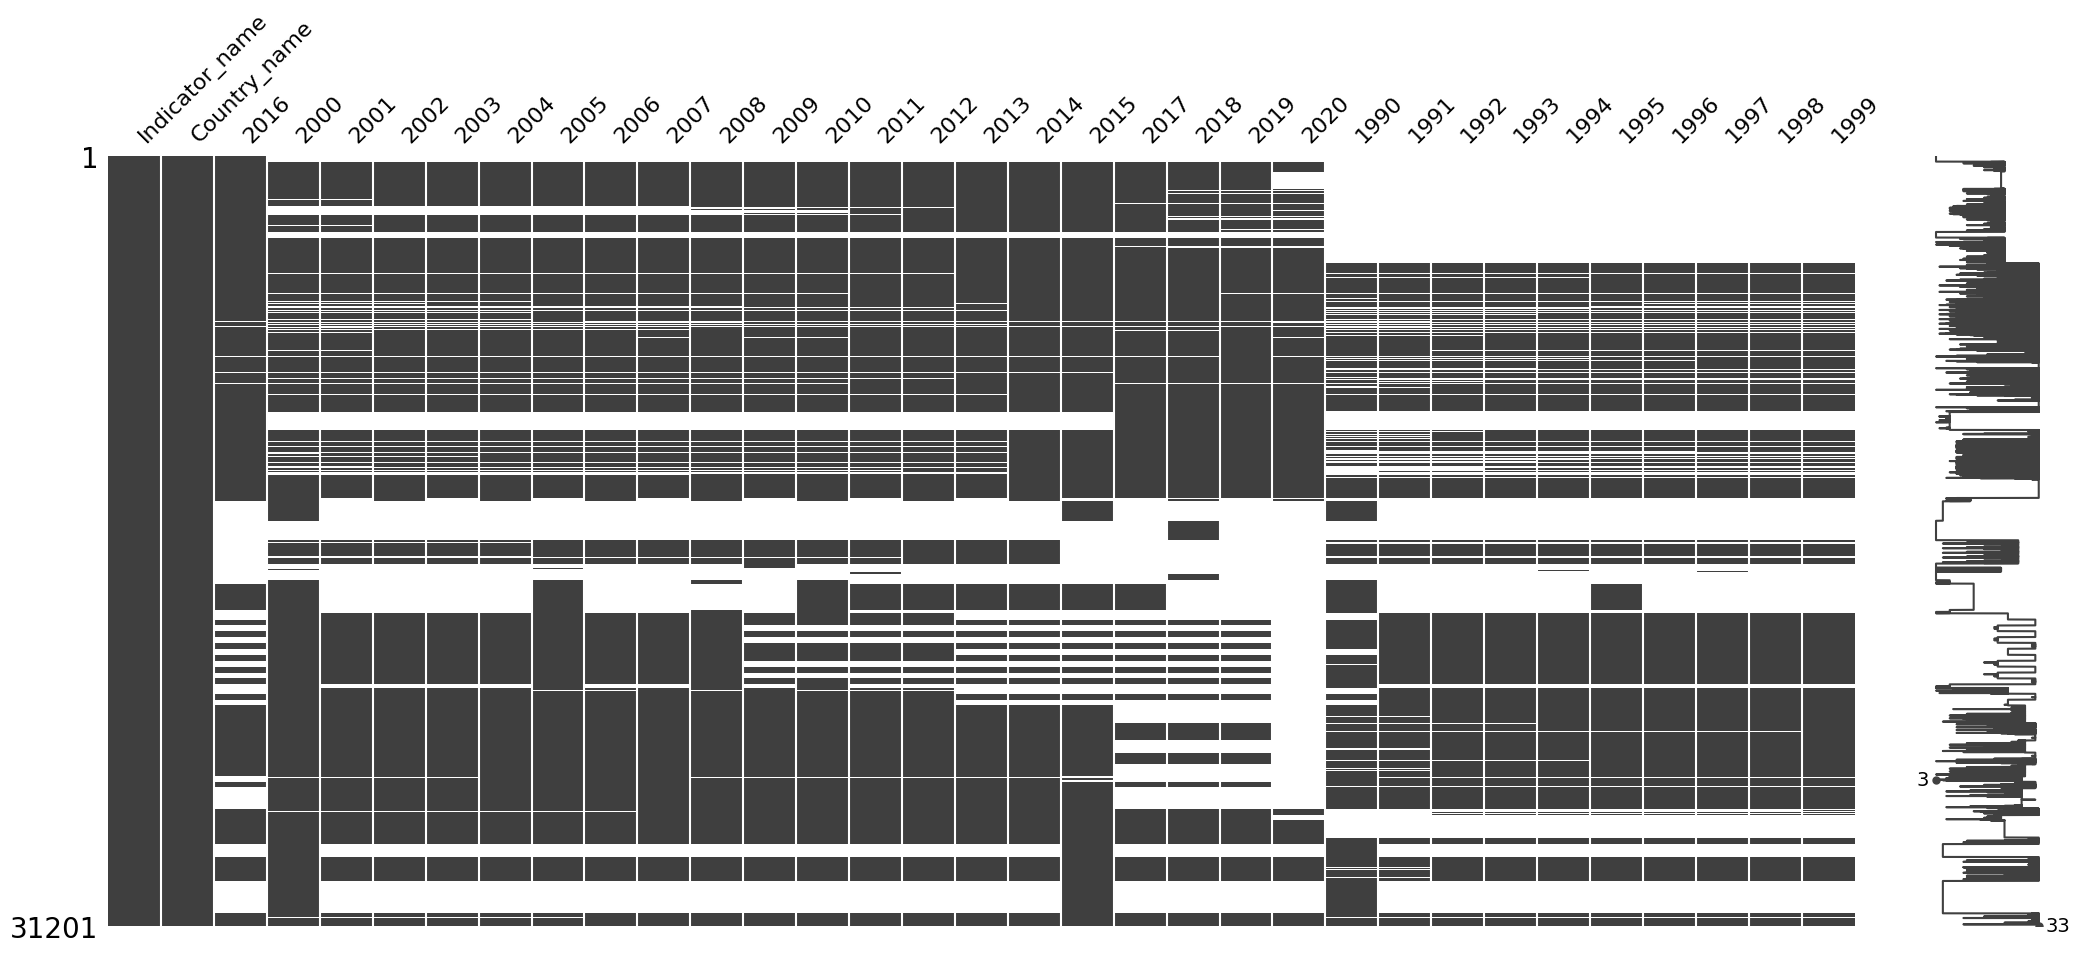

In [181]:
environment_df = create_df(indicators, (1990,2020))
msno.matrix(environment_df)

In [73]:
environment_df.head()

date,Indicator_name,Country_name,2016,2000,2001,2002,2003,2004,2005,2006,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,"Mortality rate attributed to unsafe water, uns...",1A,7.316462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Mortality rate attributed to unsafe water, uns...",1W,11.823676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Mortality rate attributed to unsafe water, uns...",4E,2.219411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Mortality rate attributed to unsafe water, uns...",7E,0.367145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Mortality rate attributed to unsafe water, uns...",8S,17.834964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
environment_df['Indicator_name'].unique()

array(['Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)',
       'People using safely managed sanitation services (% of population)',
       'People using safely managed sanitation services, urban (% of urban population)',
       'People using safely managed sanitation services, rural (% of rural population)',
       'Mortality rate attributed to unintentional poisoning, male (per 100,000 male population)',
       'Mortality rate attributed to unintentional poisoning, female (per 100,000 female population)',
       'Mortality rate attributed to unintentional poisoning (per 100,000 population)',
       'People practicing open defecation (% of population)',
       'People practicing open defecation, urban (% of urban population)',
       'People practicing open defecation, rural (% of rural population)',
       'People with basic handwashing facilities including soap and water (% of population)',
       'People with basic handwash

In [183]:
erased_indicators = ['Adjusted net savings, excluding particulate emission damage (current US$)',
 'Adjusted net savings, including particulate emission damage (current US$)',
 'Adjusted savings: net national savings (current US$)',
 'Adjusted savings: particulate emission damage (current US$)',
 'Adjusted savings: energy depletion (current US$)',
 'Adjusted savings: mineral depletion (current US$)',
 'Adjusted savings: consumption of fixed capital (current US$)',
 'Adjusted savings: net forest depletion (current US$)',
 'Adjusted savings: carbon dioxide damage (current US$)',
 'Adjusted savings: education expenditure (current US$)',
 'Renewable internal freshwater resources, total (billion cubic meters)',
 'Annual freshwater withdrawals, total (billion cubic meters)',
 'Nitrous oxide emissions in energy sector (thousand metric tons of CO2 equivalent)',
 'Agricultural nitrous oxide emissions (thousand metric tons of CO2 equivalent)',
 'Agricultural methane emissions (thousand metric tons of CO2 equivalent)',
 'CO2 emissions from solid fuel consumption (kt)',
 'CO2 emissions (kg per 2017 PPP $ of GDP)',
 'CO2 emissions (kg per PPP $ of GDP)',
 'CO2 emissions from liquid fuel consumption (kt)',
 'CO2 emissions (kt)',
 'CO2 emissions from gaseous fuel consumption (kt)',
 'Electricity production from renewable sources, excluding hydroelectric (kWh)',
 'Forest area (sq. km)',
 'Urban land area where elevation is below 5 meters (sq. km)',
 'Rural land area where elevation is below 5 meters (sq. km)',
 'Surface area (sq. km)',
 'Land area (sq. km)',
 'Average precipitation in depth (mm per year)'
                    ]

In [74]:
environment_df = environment_df[~environment_df['Indicator_name'].isin(erased_indicators)]

<Axes: >

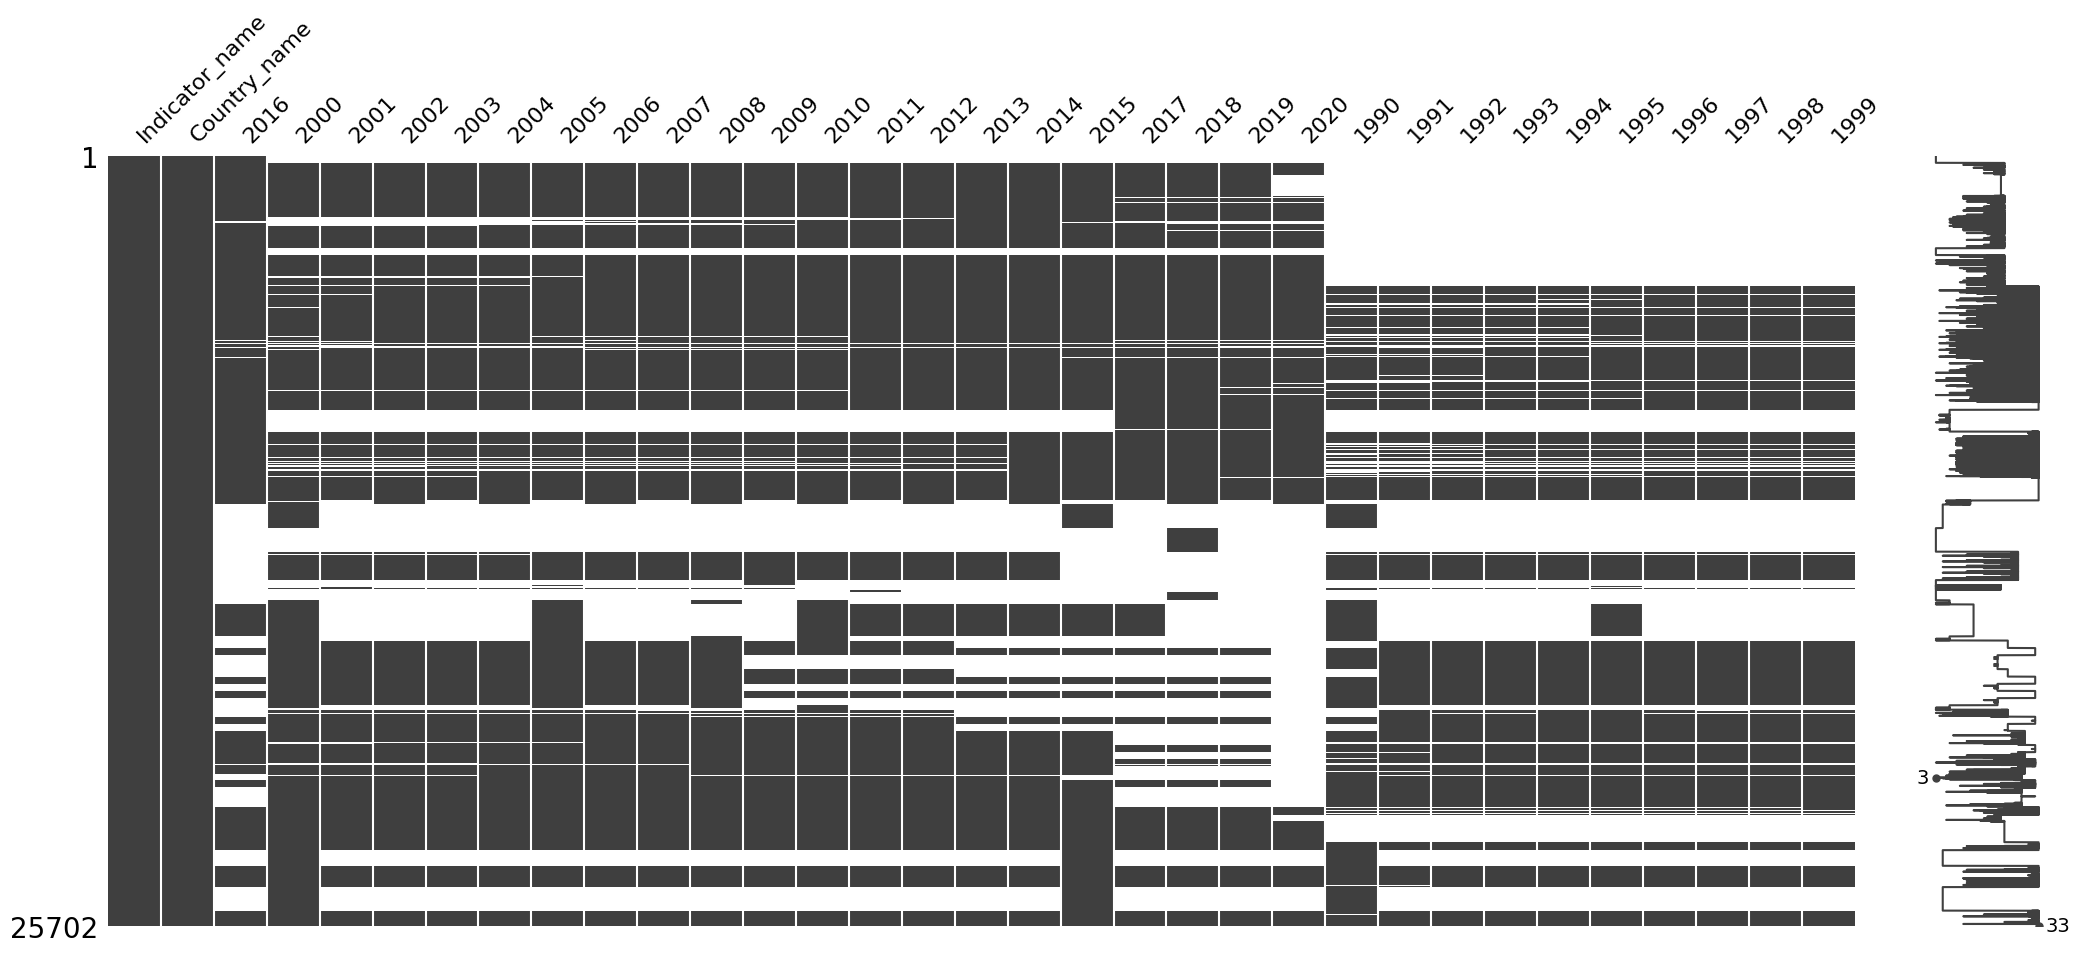

In [75]:
msno.matrix(environment_df)

In [178]:
def missing_val(df):
    """Drop either indicators or country with too little data to impute."""
    missing_indi = []
    for indi in df['Indicator_name'].unique():
        indi_df = df[df['Indicator_name'] == indi]
        missing_value = (indi_df.isnull().sum().sum() / (indi_df.shape[0]*indi_df.shape[1])*100)
        if missing_value > 50:
            missing_indi.append(indi)
    missing_country = []
    for country in df['Country_name'].unique():
        country_df = df[df['Country_name'] == country]
        missing_value = (country_df.isnull().sum().sum() / (indi_df.shape[0]*country_df.shape[1])*100)
        if missing_value > 50:
            missing_indi.append(country)
    df = df[~df['Indicator_name'].isin(missing_indi)]
    df = df[~df['Indicator_name'].isin(missing_country)]
    print(f'{len(missing_indi)} indicators were dropped and {len(missing_country)} were dropped.')

In [182]:
environment_df = missing_val(environment_df)

34 indicators were dropped and 0 were dropped.


In [82]:
environment_df.to_csv('environment_df.csv', index=False)

In [43]:
environment_df_impute = pd.read_csv('environment_df_impute.csv')
weights = pd.read_csv('weights.csv')

In [44]:
def year_mean(n,df):
    """Calculate the mean of the values other n years"""
    df = df.melt(id_vars=['Country_name', 'Indicator_name', 'impute_batch'], var_name='date')
    df['date'] = pd.to_datetime(df['date'], format='%Y')
    df = df.set_index('date')
    df = df.groupby(['Indicator_name', 'Country_name', 'impute_batch']).resample(f'{n}Y').mean()
    return df
    
def scale_feats(df, scaler):
    """Scale the features to be comparable"""
    df['value_scaled'] = df.groupby(['Indicator_name', 'date', 'impute_batch'])['value'].transform(scaler)
    return df

def compute_score(df, weights):
    """Add weights to the indicators, calculate the mean of all the indicators,
    using the logistic function to bring the score between 0 and 10,
    finally calculate the mean and the standard deviation for the impute batches."""
    df = df.reset_index()
    df = df.merge(weights, left_on="Indicator_name", right_on="Indicator_name", how="left")
    df['value_weighted'] = df['value_scaled']*df['weights']
    df = df.groupby(['Country_name', 'date','impute_batch'])['value_weighted'].agg('mean').reset_index()
    df['log_value'] = df['value_weighted'].apply(lambda x: ((10/(1+np.exp(-x)))))
    df = df.groupby(['Country_name', 'date'])['log_value'].agg(['mean', 'std']).reset_index()
    return df
    
def calculate_score(df, weights, n=3, scaler = zscore,):
    """Calculate the score using the imputed data."""
    print('\r....Calculating mean over the years....', end='')
    df_mean = year_mean(3, df)
    print('\r..........Scaling the features.........', end='')
    df_scaled = scale_feats(df_mean, scaler)
    print('\r..........Computing the score..........', end='')
    df_score = compute_score(df_scaled, weights)
    return df_score

In [45]:
environment_score = calculate_score(environment_df_impute,weights)

..........Computing the score..........

In [48]:
environment_score

,Country_name,date,mean,std
0,1A,1990-12-31,4.925357,0.016412
1,1A,1993-12-31,4.880570,0.008160
2,1A,1996-12-31,4.831948,0.009268
3,1A,1999-12-31,4.879486,0.004128
4,1A,2002-12-31,4.855976,0.000571
...,...,...,...,...
2899,ZW,2008-12-31,4.028484,0.001515
2900,ZW,2011-12-31,4.405752,0.002785
2901,ZW,2014-12-31,4.382033,0.002454
2902,ZW,2017-12-31,4.337648,0.001144


In [50]:
world_map = gpd.read_file('custom_a2.geojson')

In [67]:
def draw_map(df_score, world_map):
    n_plots = len(df_score['date'].unique())
    
    fig, ax = plt.subplots(nrows = n_plots, ncols = 2,figsize=(20, 6*n_plots))
    
    for n,date in enumerate(df_score['date'].unique()):
        df_date = df_score[df_score['date'] == date]
        df_date = df_date.drop(labels = ['date'], axis=1)
        merged_data = world_map.merge(df_date, left_on="sov_a3", right_on="Country_name", how="left")
        
        merged_data.plot(column='mean', cmap='coolwarm', legend=True, ax=ax[n,0])
        ax[n,0].set_title(f'Environment Score {str(date).split("-")[0]}')
        
        merged_data.plot(column='std', cmap='coolwarm', legend=True, ax=ax[n,1])
        ax[n,1].set_title(f'Standard Deviation {str(date).split("-")[0]}')
        
    plt.show()

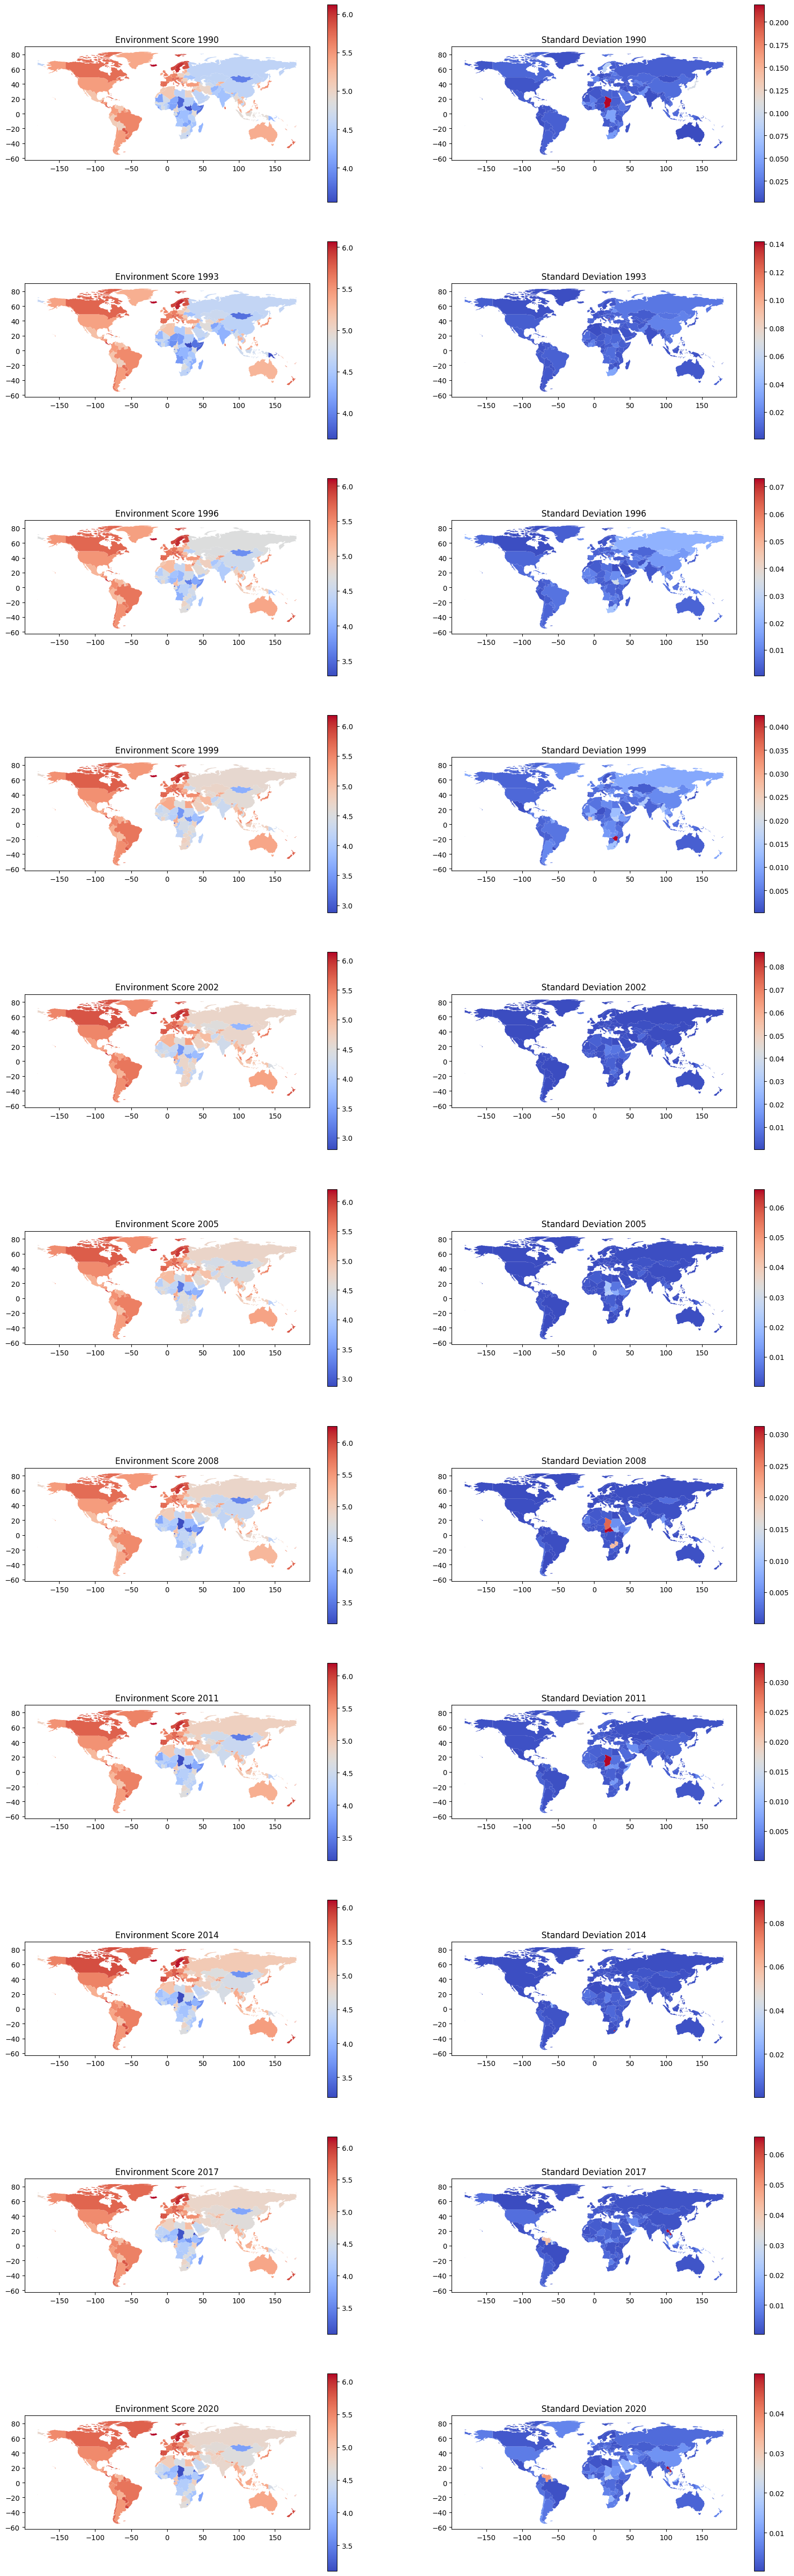

In [68]:
draw_map(environment_score, world_map)

In [182]:
def fit_arima(df_country, year):
    """Fit and predict the value for the year"""
    country = df_country['Country_name'].unique()[0]
    df_country = df_country.drop(labels=['Country_name','std'], axis=1).set_index('date')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = ARIMA(df_country, order=(1,1,0))
        model_fit = model.fit()
    predict_df = model_fit.get_forecast(f'{year}-12-31').summary_frame()
    predict = predict_df.iloc[-1,0]
    predict_std = predict_df.iloc[-1,1]
    predict_dict = {'date' : [f'{year}-12-31'],
                    'Country_name' : [country],
                    'predict' : [predict],
                    'predict_std' : [predict_std]
                   }
    return pd.DataFrame(predict_dict)

In [193]:
def fit_arima(df_country, year):
    """Fit and predict the value for the year"""
    country = df_country['Country_name'].unique()[0]
    df_country = df_country.drop(labels=['Country_name','std'], axis=1).set_index('date')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        model = ARIMA(df_country, order=(1,1,0))
        model_fit = model.fit()
    predict_df = model_fit.get_forecast(f'{year}-12-31').summary_frame()
    predict = predict_df.iloc[-1,0]
    predict_std = predict_df.iloc[-1,1]
    predict_dict = {'date' : [f'{year}-12-31'],
                    'Country_name' : [country],
                    'predict' : [predict],
                    'predict_std' : [predict_std]
                   }
    return pd.DataFrame(predict_dict)

def forecast(df, world_map, year):
    full_df = pd.DataFrame()
    for country in df['Country_name'].unique():
        df_country = df[df['Country_name'] == country]
        full_df = pd.concat([full_df, fit_arima(df_country, year)])
        
    fig, ax = plt.subplots(ncols = 2, figsize=(20, 6))
    merged_data = world_map.merge(full_df, left_on="sov_a3", right_on="Country_name", how="left")
        
    merged_data.plot(column='predict', cmap='coolwarm', legend=True, ax=ax[0])
    ax[0].set_title(f'Environment Score {year}')
        
    merged_data.plot(column='predict_std', cmap='coolwarm', legend=True, ax=ax[1])
    ax[1].set_title(f'Standard Deviation {year}')
        
    plt.show()
    return full_df

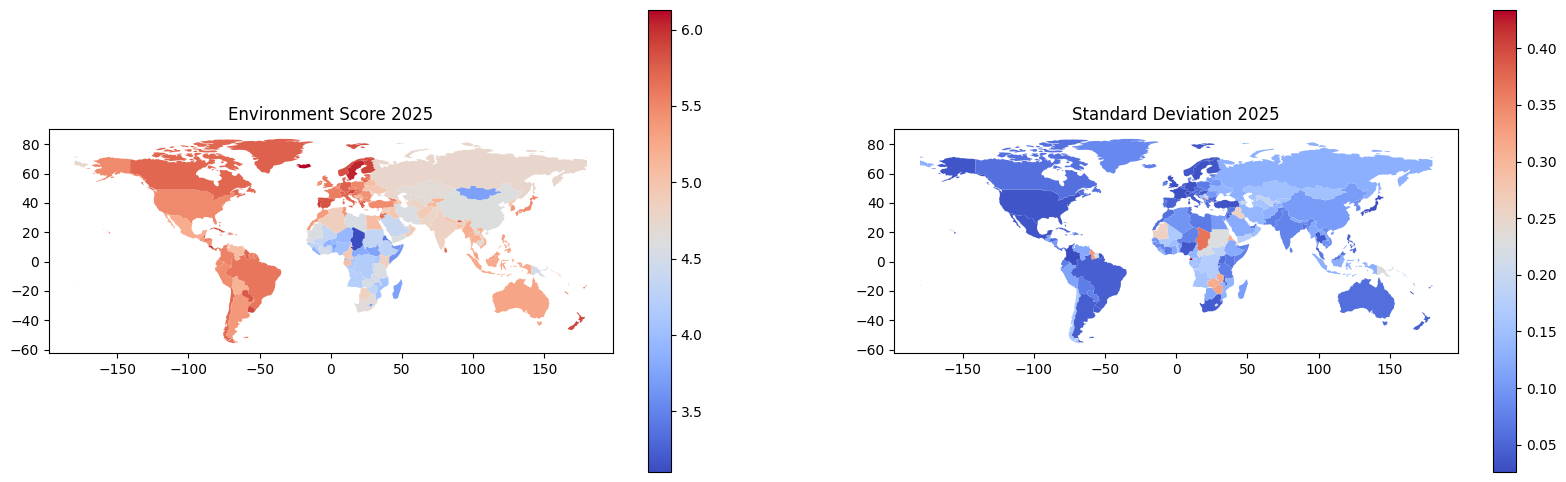

In [194]:
environment_score_2025 = forecast(environment_score, world_map, 2025)

In [196]:
environment_score_2025

,date,Country_name,predict,predict_std
0,2025-12-31,1A,4.793336,0.057926
0,2025-12-31,1W,4.036241,0.046066
0,2025-12-31,4E,4.616323,0.082448
0,2025-12-31,7E,5.014055,0.084260
0,2025-12-31,8S,4.812651,0.063688
...,...,...,...,...
0,2025-12-31,ZJ,5.338589,0.029701
0,2025-12-31,ZM,4.534214,0.312264
0,2025-12-31,ZQ,4.945941,0.048352
0,2025-12-31,ZT,4.026912,0.060555


In [178]:
df_country = fit_arima(environment_score[environment_score['Country_name'] == 'ZW'],2025)


/home/nico/miniconda3/envs/wrk/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3A-DEC will be used.
  self._init_dates(dates, freq)
/home/nico/miniconda3/envs/wrk/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3A-DEC will be used.
  self._init_dates(dates, freq)
/home/nico/miniconda3/envs/wrk/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 3A-DEC will be used.
  self._init_dates(dates, freq)


In [179]:
df_country

,date,Country_name,predict,predict_std
0,2025-12-31,ZW,4.319477,0.320776


In [144]:
model_fit.get_forecast('2025-12-31').summary_frame()

mean,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-12-31,4.747016,0.081851,4.586591,4.907440
2026-12-31,4.745658,0.128441,4.493919,4.997398
